In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '497e970670f141de9d9071f3087ea85d')

In [4]:
path = Path("big_cats")

In [5]:
big_cat_types = ['tiger','leopard','lion','cougar','snow leopard','cheetah','jaguar']

In [6]:
if not path.exists():
    path.mkdir()
    for o in big_cat_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'animal {o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [7]:
fns= get_image_files(path)
fns

(#1041) [Path('big_cats/tiger/00000111.jpg'),Path('big_cats/tiger/00000035.jpg'),Path('big_cats/tiger/00000108.jpg'),Path('big_cats/tiger/00000012.jpg'),Path('big_cats/tiger/00000034.jpg'),Path('big_cats/tiger/00000123.jpg'),Path('big_cats/tiger/00000077.jpg'),Path('big_cats/tiger/00000147.jpg'),Path('big_cats/tiger/00000124.jpg'),Path('big_cats/tiger/00000096.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#13) [Path('big_cats/tiger/00000036.jpg'),Path('big_cats/cougar/00000019.jpg'),Path('big_cats/cougar/00000120.jpg'),Path('big_cats/jaguar/00000147.jpg'),Path('big_cats/jaguar/00000092.jpg'),Path('big_cats/jaguar/00000003.jpg'),Path('big_cats/leopard/00000129.jpg'),Path('big_cats/leopard/00000099.jpg'),Path('big_cats/snow leopard/00000069.jpg'),Path('big_cats/snow leopard/00000088.jpg')...]

In [9]:
failed.map(Path.unlink);

In [10]:
big_cats = DataBlock(
    blocks= (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed =420),
    get_y = parent_label,
    item_tfms = Resize(128))

In [11]:
dls = big_cats.dataloaders(path, bs=32)

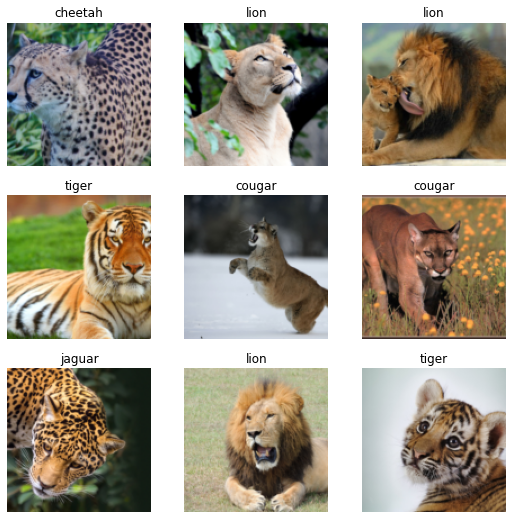

In [12]:
dls.show_batch()

In [13]:
big_cats = big_cats.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms = aug_transforms())

dls = big_cats.dataloaders(path)

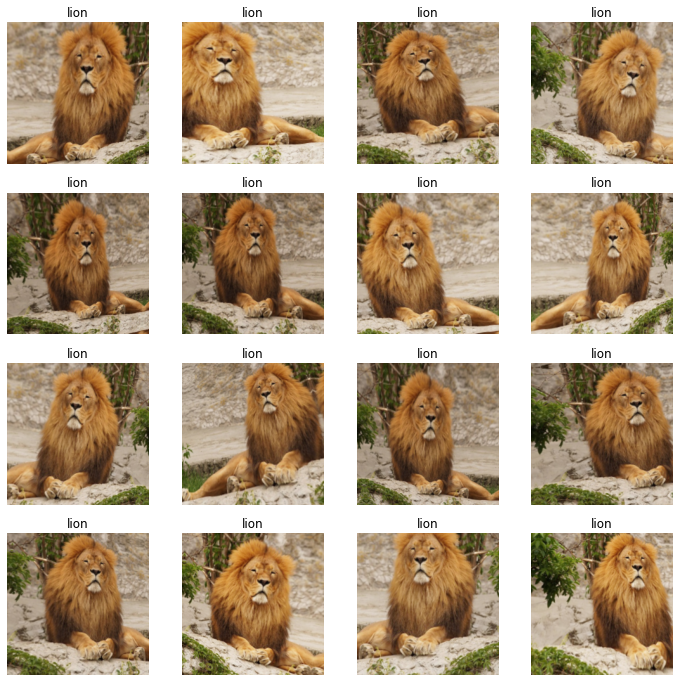

In [14]:
dls.show_batch(max_n=16, nrows=4, unique=True)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics= error_rate)

learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.704571,0.894973,0.204878,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.692958,1.061979,0.248780,00:14
1,0.598232,1.070746,0.219512,00:13
2,0.498957,0.985599,0.243902,00:14


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9)

In [ ]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)